# Capstone 3: Step 4 - Pre-processing and Training Data Development

### **The Data Science Method**  


1.   Problem Identification 

2.   Data Wrangling 
  
3.   Exploratory Data Analysis 
 
4.   **Pre-processing and Training Data Development**

5.  Modeling
  * Fit Models with Training Data Set
  * Review Model Outcomes — Iterate over additional models as needed.
  * Identify the Final Model

6.   Documentation
  * Review the Results
  * Present and share your findings - storytelling
  * Finalize Code 
  * Finalize Documentation

In [1]:
#load python packages
import os
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import kpss
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
import warnings
import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from fbprophet import Prophet
# print the current working directory
print(os.getcwd())

C:\Users\Nancy\Documents\GitHub\Springboard\Capstone 3 elementary OS revenue projection


In [2]:
pd.set_option('display.max_columns',None)

## Load the data

In [3]:
df=pd.read_csv('data\step2_output.csv')

C:\Users\Nancy\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (16,17) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# change the Created (UTC) to a datetime object
df['Created (UTC)']=pd.to_datetime(df['Created (UTC)'])

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Amount,67511.0,6.009428,6.673728,1.00,1.00,5.00,10.00,340.00
Fee,67511.0,0.493294,0.225631,0.01,0.34,0.45,0.59,13.56
Destination Platform Fee,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Net,67511.0,5.516133,6.455838,0.66,0.67,4.55,9.31,326.44
Customer Facing Amount,67511.0,6.009428,6.673728,1.00,1.00,5.00,10.00,340.00
Transfer Group,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
name (metadata),0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
email (metadata),0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
phone (metadata),0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
order (metadata),0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [115]:
# only use data through the end of June 2020
mask = (df['Created (UTC)'] < '2020-7-1')
dfkeep = df.loc[mask]

## Create dataframe indexed by date

In [116]:
dfsum = dfkeep.groupby([dfkeep['Created (UTC)'].dt.date])[['Amount']].sum()

In [117]:
print(dfsum.head())
print(dfsum.tail())

               Amount
Created (UTC)        
2016-03-01       5.00
2016-03-02      56.50
2016-03-03     185.69
2016-03-04     156.99
2016-03-05     143.00
               Amount
Created (UTC)        
2020-06-26     296.41
2020-06-27     412.17
2020-06-28     273.18
2020-06-29     189.04
2020-06-30     300.97


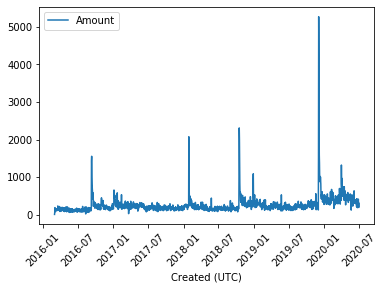

In [118]:
# plot the time series
dfsum.plot(rot=45)

# Capstone 3: Step 5 - Modeling

In [119]:
# load holidays dataframe
holidays=pd.read_csv('data\holidays.csv',parse_dates=['ds'])

In [120]:
# instantiate Prophet model
model1=Prophet(holidays=holidays, holidays_prior_scale=80, daily_seasonality=True, seasonality_mode='multiplicative') # by default is 80%

In [121]:
dfsum.head()

,Amount
Created (UTC),
2016-03-01,5.00
2016-03-02,56.50
2016-03-03,185.69
2016-03-04,156.99
2016-03-05,143.00


In [122]:
# reformat data to match Prophet requirements
dfmodel = dfsum
dfmodel.columns=['y_orig']
dfmodel['ds']=dfmodel.index
dfmodel.head()

,y_orig,ds
Created (UTC),,
2016-03-01,5.00,2016-03-01
2016-03-02,56.50,2016-03-02
2016-03-03,185.69,2016-03-03
2016-03-04,156.99,2016-03-04
2016-03-05,143.00,2016-03-05


In [123]:
# log transform the y variable to try to convert from non-stationary to stationary
dfmodel['y']=np.log(dfmodel['y_orig'])

In [124]:
# Split data between train and test
split=int(len(dfmodel) * 0.8) 
# Make train and test variables, with 'train, test'
train, test = dfmodel[0:split], dfmodel[split:len(dfmodel)]



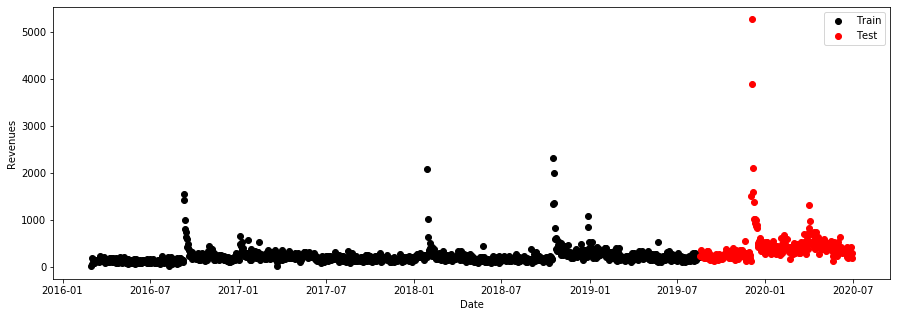

In [125]:
# plot data
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(train['ds'], train['y_orig'], linestyle='None', marker='o', color='black', label='Train')
ax.plot(test['ds'], test['y_orig'], linestyle='None', marker='o', color='red', label='Test')
ax.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Revenues');

### Fit the model on the training dataset

In [126]:
# fit Prophet model with training data
model1.fit(train)

### run predict on all of the data (both train and test)

In [127]:
forecast = model1.predict(dfmodel)

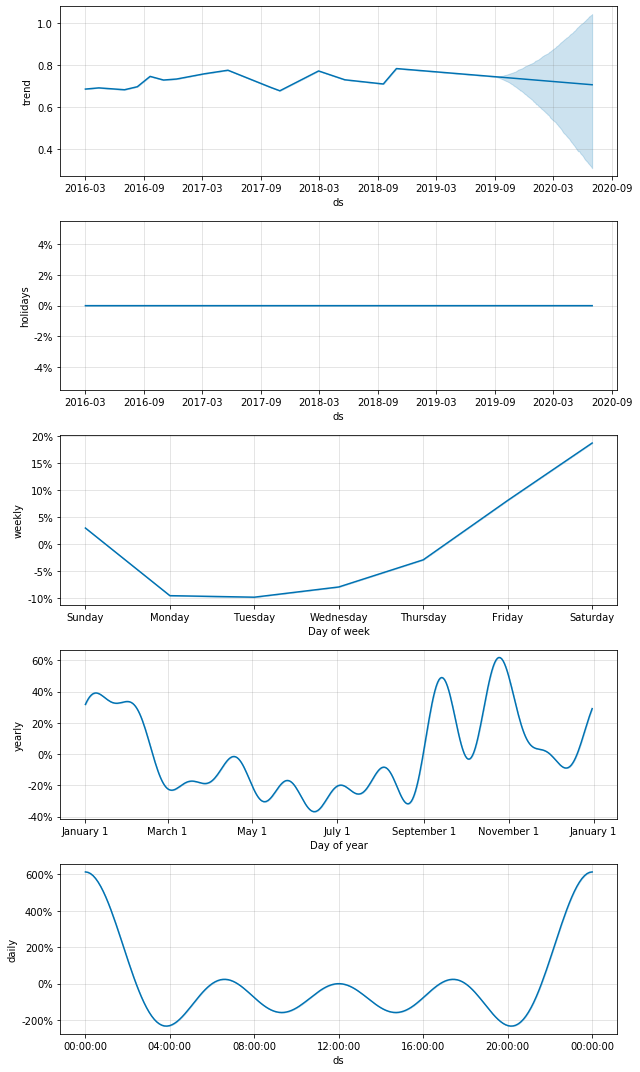

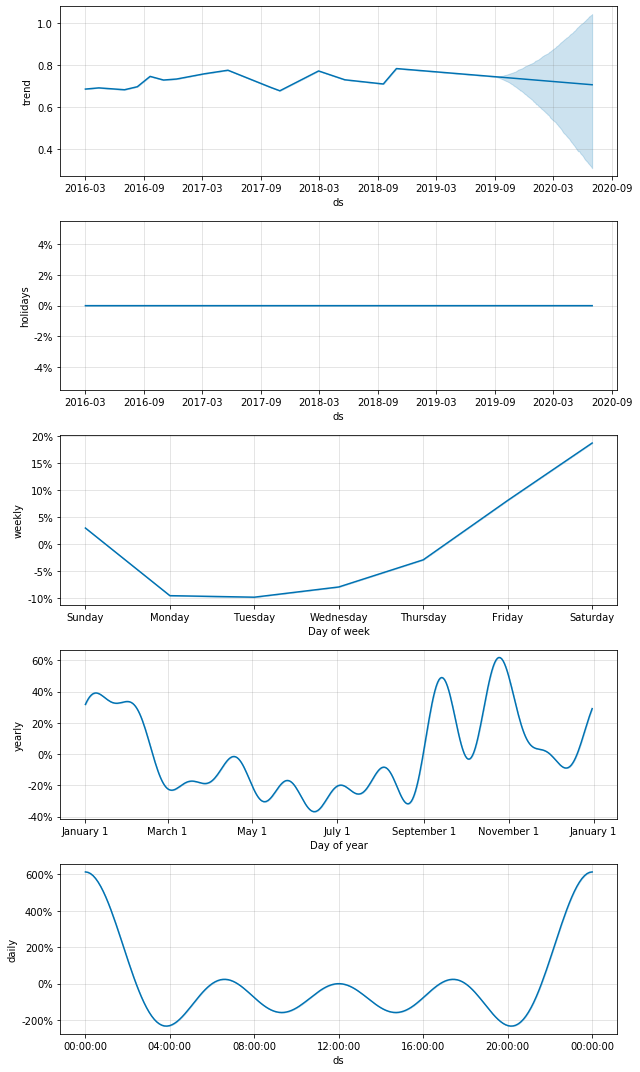

In [128]:
# plot outcomes
model1.plot_components(forecast)

### Plot forecast, train and test dataset

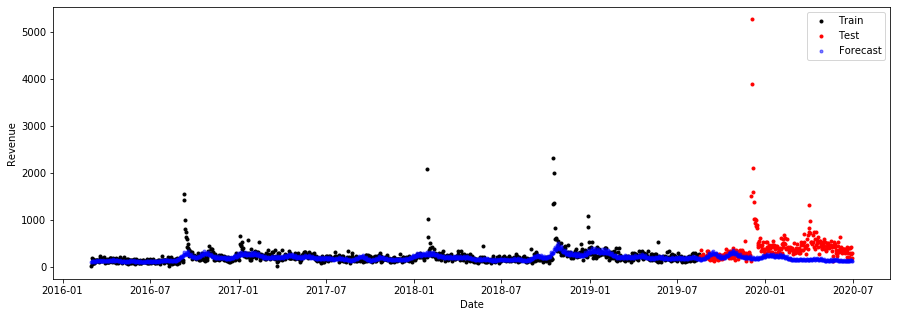

In [129]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(train['ds'], train['y_orig'], c='black', marker='o', ms=3, linestyle='None', label='Train')
ax.plot(test['ds'], test['y_orig'], c='r', marker='o', ms=3, linestyle='None', label='Test')
ax.plot(forecast['ds'], np.exp(forecast['yhat']), c='b', marker='o', ms=3, linestyle='None', label='Forecast', alpha=0.5)
ax.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Revenue');